In [ ]:
# ==== This notebook demonstrates how to evaluate the multi-class classification of the CLIP / BiomedCLIP model ====


import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, CLIPProcessor, CLIPModel
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from torch import nn
import json
import random
import pandas as pd

# Set the Hugging Face cache directory
# This is necessary to avoid downloading the model and tokenizer every time.
# You can change the path to your desired cache directory.
os.environ["HF_HOME"] = "/data/username/.cache/huggingface"

In [ ]:
# Load the biomed CLIP model and tokenizer from Hugging Face Hub
# The trained weights are saved locally, but the model architecture and tokenizer are loaded from the Hugging Face Hub.


clip_model_name = "openai/clip-vit-base-patch32"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load base CLIP model and tokenizer/processor
clip_model = CLIPModel.from_pretrained(clip_model_name).to(device)
processor = CLIPProcessor.from_pretrained(clip_model_name)
tokenizer = AutoTokenizer.from_pretrained(clip_model_name)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# Load the biomed CLIP model and tokenizer from Hugging Face Hub
# The trained weights are saved locally, but the model architecture and tokenizer are loaded from the Hugging Face Hub.

class CLIPMultiTaskClassifier(nn.Module):
    def __init__(self, clip_model, embed_dim=512):
        super().__init__()
        self.clip = clip_model
        self.embed_dim = embed_dim

        # Freeze CLIP backbone
        for param in self.clip.parameters():
            param.requires_grad = False

        # Trainable binary classification head
        self.binary_cls_head = nn.Linear(embed_dim, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, pixel_values, input_ids, attention_mask=None):
        """
        Args:
            pixel_values: Tensor [B, 3, H, W]
            input_ids: Tensor [B, L]
            attention_mask: Tensor [B, L] or None
        Returns:
            Dict with binary logits and features
        """
        # Inputs must be passed as dicts
        with torch.no_grad():
            image_embeds = self.clip.get_image_features(pixel_values=pixel_values)  # [B, D]
            text_embeds = self.clip.get_text_features(input_ids=input_ids, attention_mask=attention_mask)  # [B, D]

        fused = (image_embeds + text_embeds) / 2
        fused = self.dropout(fused)
        binary_logits = self.binary_cls_head(fused).squeeze(-1)  # [B]

        return {
            "binary_logits": binary_logits,
            "image_embeds": image_embeds,
            "text_embeds": text_embeds,
        }

In [10]:
# ==== Create the classifier with the clip model ====
classifier = CLIPMultiTaskClassifier(clip_model).to(device)

In [ ]:
# ==== define the evaluation dataset ====
from torch.utils.data import Dataset
from PIL import Image

# The dataset class for loading the JSON files and images
class BiomedCLIPMultiTaskFromJSON(Dataset):
    def __init__(self, json_dir, image_dir, processor, device="cuda"):
        self.json_paths = sorted([
            os.path.join(json_dir, fname)
            for fname in os.listdir(json_dir)
            if fname.endswith(".json")
        ])
        self.image_dir = image_dir
        self.processor = processor
        self.device = device

    def __len__(self):
        return len(self.json_paths)

    def __getitem__(self, idx):
        json_path = self.json_paths[idx]
        with open(json_path, "r") as f:
            data = json.load(f)

        # Get caption
        caption = str(data.get("caption", "")).strip()

        # Get label
        normal_flag = str(data.get("normal", "")).strip().lower()
        label = 0 if normal_flag == "yes" else 1

        # Load image
        stem = data.get("file_name", os.path.splitext(os.path.basename(json_path))[0])
        image_path = os.path.join(self.image_dir, f"{stem}.jpg")
        image = Image.open(image_path).convert("RGB")

        return {
            "caption": caption,
            "image": image,
            "label": torch.tensor(label, dtype=torch.long),
            "image_path": image_path
        }

In [12]:
def collate_fn(batch, processor):
    images = [item["image"] for item in batch]
    captions = [item["caption"] for item in batch]
    labels = torch.stack([item["label"] for item in batch])
    image_paths = [item["image_path"] for item in batch]

    processed = processor(
        text=captions,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True
    )

    return {
        "input_ids": processed["input_ids"],
        "attention_mask": processed["attention_mask"],
        "pixel_values": processed["pixel_values"],
        "label": labels,
        "image_path": image_paths,
    }

In [ ]:
from functools import partial
from torch.utils.data import DataLoader

json_dir = "/data/username/indiana/data/test/caption"
image_dir = "/data/username/indiana/data/test/image"

# Dataset and DataLoader
test_dataset = BiomedCLIPMultiTaskFromJSON(
    json_dir=json_dir,
    image_dir=image_dir,
    processor=processor,
    device=device
)

test_loader = DataLoader(
    test_dataset,
    batch_size=50,
    shuffle=True,
    num_workers=4,
    collate_fn=partial(collate_fn, processor=processor)
)

In [ ]:
# ==== Function to extract embeddings and metadata ====

def extract_embeddings_and_metadata(model, dataloader, device="cuda"):
    """
    Extract image, text, and fused embeddings from the CLIP model,
    along with image paths and binary labels from the dataloader.

    Returns:
        dict with:
            - image_feats: np.ndarray [N, D]
            - text_feats: np.ndarray [N, D]
            - fused_feats: np.ndarray [N, D]
            - image_paths: List[str]
            - labels: List[int]
    """
    model.eval()
    image_embeds_all, text_embeds_all, fused_embeds_all = [], [], []
    image_paths_all = []
    label_all = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting embeddings"):
            input_ids = batch["input_ids"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            paths = batch["image_path"]
            labels = batch["label"]

            # Encode
            image_feat = model.clip.get_image_features(pixel_values)
            text_feat = model.clip.get_text_features(input_ids)

            # Normalize
            image_feat = F.normalize(image_feat, dim=1)
            text_feat = F.normalize(text_feat, dim=1)
            fused_feat = F.normalize((image_feat + text_feat) / 2, dim=1)

            # Accumulate features and metadata
            image_embeds_all.append(image_feat.cpu())
            text_embeds_all.append(text_feat.cpu())
            fused_embeds_all.append(fused_feat.cpu())
            image_paths_all.extend(paths)
            label_all.extend(labels.cpu().tolist())

    # Stack tensors to numpy arrays
    image_feats = torch.cat(image_embeds_all).numpy().astype("float32")
    text_feats = torch.cat(text_embeds_all).numpy().astype("float32")
    fused_feats = torch.cat(fused_embeds_all).numpy().astype("float32")

    # Validate
    assert (
        len(image_paths_all) == len(label_all) == image_feats.shape[0]
    ), "Mismatch in collected data dimensions"

    return {
        "image_feats": image_feats,
        "text_feats": text_feats,
        "fused_feats": fused_feats,
        "image_paths": image_paths_all,
        "labels": label_all,
    }

In [16]:
results = extract_embeddings_and_metadata(classifier, test_loader, device=device)
image_feats = results["image_feats"]
text_feats = results["text_feats"]
fused_feats = results["fused_feats"]
image_paths = results["image_paths"]
labels = results["labels"]

Extracting embeddings:   0%|          | 0/8 [00:00<?, ?it/s]

In [19]:
import faiss
import pickle
import numpy as np

def save_all_faiss_indices(
    image_feats: np.ndarray,
    text_feats: np.ndarray,
    fused_feats: np.ndarray,
    image_paths: list,
    labels: list,
    out_dir: str = "/data/liangz2/indiana/data/test/faiss"
):
    """
    Save FAISS indices and metadata (image paths, labels) for retrieval tasks.

    Args:
        image_feats (np.ndarray): [N, D] normalized image embeddings
        text_feats (np.ndarray): [N, D] normalized text embeddings
        fused_feats (np.ndarray): [N, D] normalized fused (image + text) embeddings
        image_paths (list): list of image file paths (length N)
        labels (list): list of single-label class indices (length N)
        out_dir (str): output directory to store indices and metadata
    """
    os.makedirs(out_dir, exist_ok=True)

    def save_index(feats, name):
        index_path = os.path.join(out_dir, f"{name}_index.faiss")
        index = faiss.IndexFlatIP(feats.shape[1])  # Inner product for cosine sim (with normalized vectors)
        index.add(feats)
        faiss.write_index(index, index_path)
        print(f"✅ Saved {name} index to {index_path}")

    # Save FAISS indices
    save_index(image_feats, "image")
    save_index(text_feats, "text")
    save_index(fused_feats, "fused")

    # Save associated metadata
    meta_path = os.path.join(out_dir, "metadata.pkl")
    metadata = {
        "image_paths": image_paths,
        "labels": labels,
    }

    with open(meta_path, "wb") as f:
        pickle.dump(metadata, f)

    print(f"📦 Metadata saved to {meta_path}")

In [20]:
save_all_faiss_indices(
    image_feats=image_feats,
    text_feats=text_feats,
    fused_feats=fused_feats,
    image_paths=image_paths,
    labels=labels,
)

✅ Saved image index to /data/liangz2/indiana/data/test/faiss/image_index.faiss
✅ Saved text index to /data/liangz2/indiana/data/test/faiss/text_index.faiss
✅ Saved fused index to /data/liangz2/indiana/data/test/faiss/fused_index.faiss
📦 Metadata saved to /data/liangz2/indiana/data/test/faiss/metadata.pkl


In [22]:
def load_all_faiss_indices(base_dir="/data/liangz2/indiana/data/test/faiss"):
    """
    Load FAISS indices and metadata (image paths and single-labels).

    Returns:
        dict: {
            'image_index': faiss.Index,
            'text_index': faiss.Index,
            'fused_index': faiss.Index,
            'image_paths': list of str,
            'labels': list of int
        }
    """
    # Paths to index and metadata files
    image_index_path = os.path.join(base_dir, "image_index.faiss")
    text_index_path = os.path.join(base_dir, "text_index.faiss")
    fused_index_path = os.path.join(base_dir, "fused_index.faiss")
    metadata_path = os.path.join(base_dir, "metadata.pkl")

    # Check for file existence
    required_files = [image_index_path, text_index_path, fused_index_path, metadata_path]
    if not all(os.path.exists(p) for p in required_files):
        raise FileNotFoundError("❌ One or more FAISS index or metadata files are missing.")

    # Load FAISS indices
    image_index = faiss.read_index(image_index_path)
    text_index = faiss.read_index(text_index_path)
    fused_index = faiss.read_index(fused_index_path)

    # Load metadata
    with open(metadata_path, "rb") as f:
        metadata = pickle.load(f)

    image_paths = metadata["image_paths"]
    labels = metadata["labels"]

    print("✅ FAISS indices and metadata successfully loaded.")
    return {
        "image_index": image_index,
        "text_index": text_index,
        "fused_index": fused_index,
        "image_paths": image_paths,
        "labels": labels
    }

In [23]:
faiss_data = load_all_faiss_indices("/data/liangz2/indiana/data/test/faiss")

✅ FAISS indices and metadata successfully loaded.


In [24]:
def retrieve_top_k_with_meta(query_vecs, index, paths, labels, top_k=5):
    """
    Retrieve top-K entries and return their paths, and labels

    Args:
        query_vecs (np.ndarray): shape [B, D], normalized vectors
        index (faiss.Index): FAISS index
        paths (List[str]): image paths
        labels (List[int]): binary label list
        top_k (int): number of top entries to return

    Returns:
        List[Dict]: List of results per query
    """
    scores, indices = index.search(query_vecs, top_k)
    results = []

    for i, idx_row in enumerate(indices):
        query_results = []
        for j in idx_row:
            result = {
                "path": paths[j],
                "label": labels[j]
            }
            query_results.append(result)
        results.append(query_results)

    return results, scores

In [26]:
with torch.no_grad():
    # Step 1: Get CLIP image features
    image_feat = classifier.clip.get_image_features(pixel_values)     # [1, D]
    image_feat = F.normalize(image_feat, dim=1)                  # [1, D]

# Step 2: Convert to numpy for FAISS
query_vec = image_feat.cpu().numpy().astype("float32")           # [1, D]

# Step 3: Ground truth
gt_label = batch["label"][0].item()
gt_path = batch["image_path"][0]

# Step 4: FAISS retrieval
retrieved, scores = retrieve_top_k_with_meta(
    query_vec,
    index=faiss_data["fused_index"],  # or image_index / text_index / fused_index
    paths=faiss_data["image_paths"],
    labels=faiss_data["labels"],
    top_k=5
)

# Step 5: Print results
print(f"\n🔍 Ground Truth Image: {gt_path}")
print(f"  Label: {gt_label}")
print("\n🎯 Retrieved Top-K:")
for i, (res, score) in enumerate(zip(retrieved[0], scores[0])):  # [0] for first query
    print(f"  Top-{i+1}: Path={res['path']}, Label={res['label']}, Score={score:.4f}")


🔍 Ground Truth Image: /data/liangz2/indiana/data/test/image/1222_IM-0150-1001.jpg
  Label: 1

🎯 Retrieved Top-K:
  Top-1: Path=/data/liangz2/indiana/data/test/image/1222_IM-0150-1001.jpg, Label=1, Score=0.8176
  Top-2: Path=/data/liangz2/indiana/data/test/image/1395_IM-0251-1001.jpg, Label=0, Score=0.8105
  Top-3: Path=/data/liangz2/indiana/data/test/image/2130_IM-0755-1001.jpg, Label=1, Score=0.8104
  Top-4: Path=/data/liangz2/indiana/data/test/image/3378_IM-1627-1001.jpg, Label=1, Score=0.8096
  Top-5: Path=/data/liangz2/indiana/data/test/image/2183_IM-0794-1001.jpg, Label=1, Score=0.8061


In [27]:
from typing import List, Dict
from tqdm import tqdm
import os
import torch
import torch.nn.functional as F

def faiss_topk_image_path_retrieval_accuracy(
    model,
    dataloader,
    faiss_index,
    faiss_paths: List[str],
    top_k_values: List[int] = [1, 3, 5],
    mode: str = "image",  # or "text"
    device: str = "cuda"
) -> Dict[str, float]:
    """
    Compute top-k retrieval accuracy based on image path match, and average similarity scores.

    Args:
        model: Wrapper with model.clip.get_image_features / get_text_features
        dataloader: test dataloader with keys ["pixel_values", "input_ids", "image_path"]
        faiss_index: FAISS index for retrieval
        faiss_paths: list of image paths in the same order as the FAISS index
        top_k_values: list of k for top-k retrieval
        mode: "image" (image→text) or "text" (text→image)
        device: CUDA or CPU

    Returns:
        Dictionary with top-k accuracy and average similarity per mode.
    """
    model.eval()
    correct_counts = {k: 0 for k in top_k_values}
    sim_sums = {k: 0.0 for k in top_k_values}
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"FAISS-{mode}-path-retrieval"):
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            gt_paths = batch["image_path"]

            # === Get query features using CLIP ===
            if mode == "image":
                query_feats = model.clip.get_image_features(pixel_values)
            elif mode == "text":
                query_feats = model.clip.get_text_features(input_ids)
            else:
                raise ValueError("mode must be 'image' or 'text'")

            query_feats = F.normalize(query_feats, dim=1)
            query_np = query_feats.cpu().numpy().astype("float32")

            scores, indices = faiss_index.search(query_np, max(top_k_values))

            for i, idx_row in enumerate(indices):
                gt_path = os.path.normpath(gt_paths[i])
                retrieved_paths = [os.path.normpath(faiss_paths[j]) for j in idx_row]
                retrieved_scores = scores[i]

                for k in top_k_values:
                    if gt_path in retrieved_paths[:k]:
                        correct_counts[k] += 1
                    sim_sums[k] += float(sum(retrieved_scores[:k]) / k)

                total += 1

    # === Compute metrics ===
    results = {}
    for k in top_k_values:
        acc = correct_counts[k] / total
        avg_sim = sim_sums[k] / total
        results[f"{mode}_faiss_top{k}_path_accuracy"] = acc
        results[f"{mode}_faiss_top{k}_avg_sim"] = avg_sim

    return results

In [28]:
image2text_path_metrics = faiss_topk_image_path_retrieval_accuracy(
    model=classifier,
    dataloader=test_loader,
    faiss_index=faiss_data["fused_index"],
    faiss_paths=faiss_data["image_paths"],
    top_k_values=[1, 3, 5, 10],
    mode="image",  # or "text"
    device=device
)
print(image2text_path_metrics)

FAISS-image-path-retrieval: 100%|██████████| 8/8 [00:17<00:00,  2.13s/it]

{'image_faiss_top1_path_accuracy': 0.8375, 'image_faiss_top1_avg_sim': 0.8186381965875625, 'image_faiss_top3_path_accuracy': 0.9375, 'image_faiss_top3_avg_sim': 0.8143187255660694, 'image_faiss_top5_path_accuracy': 0.945, 'image_faiss_top5_avg_sim': 0.8127492963671682, 'image_faiss_top10_path_accuracy': 0.9675, 'image_faiss_top10_avg_sim': 0.8108750447630879}


In [29]:
text2image_path_metrics = faiss_topk_image_path_retrieval_accuracy(
    model=classifier,
    dataloader=test_loader,
    faiss_index=faiss_data["fused_index"],
    faiss_paths=faiss_data["image_paths"],
    top_k_values=[1, 3, 5, 10],
    mode="text",
    device=device
)
print(text2image_path_metrics)

FAISS-text-path-retrieval: 100%|██████████| 8/8 [00:17<00:00,  2.14s/it]

{'text_faiss_top1_path_accuracy': 0.94, 'text_faiss_top1_avg_sim': 0.8182696650922299, 'text_faiss_top3_path_accuracy': 0.9875, 'text_faiss_top3_avg_sim': 0.8078228750824934, 'text_faiss_top5_path_accuracy': 1.0, 'text_faiss_top5_avg_sim': 0.8041550339758399, 'text_faiss_top10_path_accuracy': 1.0, 'text_faiss_top10_avg_sim': 0.7996613029688592}


In [30]:
from typing import List, Dict
from collections import Counter
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
import torch
import torch.nn.functional as F
from tqdm import tqdm

def faiss_topk_label_retrieval_metrics(
    model,
    dataloader,
    faiss_index,
    faiss_labels: List[int],
    faiss_paths: List[str],
    top_k_values: List[int] = [1, 3, 5],
    mode: str = "image",  # or "text"
    device: str = "cuda"
) -> Dict[str, float]:
    """
    Evaluate retrieval precision via FAISS based on label match (not majority voting).

    Returns:
        Dict containing:
            - Top-k label-based precision (whether GT label appears in top-k)
            - Top-k average similarity
            - Top-1 retrieval accuracy
            - F1 score, ROC AUC, mAP based on similarity score
    """
    model.eval()
    total = 0

    # Accumulators
    correct_topk = {k: 0 for k in top_k_values}
    sim_sums = {k: 0.0 for k in top_k_values}
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"FAISS-{mode}-label-retrieval"):
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            gt_labels = batch["label"].tolist()

            # Encode queries using CLIPModel
            if mode == "image":
                query_feats = model.clip.get_image_features(pixel_values)
            elif mode == "text":
                query_feats = model.clip.get_text_features(input_ids)
            else:
                raise ValueError("mode must be 'image' or 'text'")

            query_feats = F.normalize(query_feats, dim=1)
            query_np = query_feats.cpu().numpy().astype("float32")

            scores, indices = faiss_index.search(query_np, max(top_k_values))

            for i, top_indices in enumerate(indices):
                top_scores = scores[i]
                top_labels = [faiss_labels[j] for j in top_indices]
                gt = gt_labels[i]

                # Top-k metrics
                for k in top_k_values:
                    if gt in top_labels[:k]:
                        correct_topk[k] += 1
                    sim_sums[k] += float(sum(top_scores[:k]) / k)

                # Top-1 metrics
                top1_label = top_labels[0]
                sim_score = top_scores[0]

                all_labels.append(gt)
                all_scores.append((top1_label, sim_score))

                total += 1

    # Classification metrics
    y_true = torch.tensor(all_labels)
    y_pred = torch.tensor([label for label, _ in all_scores])
    y_score = torch.tensor([score for _, score in all_scores])

    y_true_bin = (y_true > 0).int()
    y_pred_bin = (y_pred > 0).int()

    f1 = f1_score(y_true_bin, y_pred_bin)
    try:
        auc = roc_auc_score(y_true_bin, y_score)
    except:
        auc = float("nan")
    ap = average_precision_score(y_true_bin, y_score)

    # Result dict
    results = {
        f"{mode}_top1_accuracy": (y_true == y_pred).sum().item() / total,
        f"{mode}_f1_score": f1,
        f"{mode}_roc_auc": auc,
        f"{mode}_mAP": ap,
    }

    for k in top_k_values:
        results[f"{mode}_faiss_top{k}_label_precision"] = correct_topk[k] / total
        results[f"{mode}_faiss_top{k}_avg_sim"] = sim_sums[k] / total

    return results

In [31]:
image2text_metrics = faiss_topk_label_retrieval_metrics(
    model=classifier,
    dataloader=test_loader,
    faiss_index=faiss_data["fused_index"],
    faiss_labels=faiss_data["labels"],
    faiss_paths=faiss_data["image_paths"],
    top_k_values=[1, 3, 5, 10],
    mode="image",
    device=device
)
print(f"image-to-text: {image2text_metrics}")

text2image_metrics = faiss_topk_label_retrieval_metrics(
    model=classifier,
    dataloader=test_loader,
    faiss_index=faiss_data["fused_index"],
    faiss_labels=faiss_data["labels"],
    faiss_paths=faiss_data["image_paths"],
    top_k_values=[1, 3, 5, 10],
    mode="text",
    device=device
)

print(f"text-to-image: {text2image_metrics}")

FAISS-image-label-retrieval: 100%|██████████| 8/8 [00:17<00:00,  2.15s/it]


image-to-text: {'image_top1_accuracy': 0.905, 'image_f1_score': 0.9112149532710281, 'image_roc_auc': 0.51345, 'image_mAP': 0.5251541520460606, 'image_faiss_top1_label_precision': 0.905, 'image_faiss_top1_avg_sim': 0.8186381965875625, 'image_faiss_top3_label_precision': 0.99, 'image_faiss_top3_avg_sim': 0.8143187255660692, 'image_faiss_top5_label_precision': 1.0, 'image_faiss_top5_avg_sim': 0.8127492963671682, 'image_faiss_top10_label_precision': 1.0, 'image_faiss_top10_avg_sim': 0.8108750447630877}


FAISS-text-label-retrieval: 100%|██████████| 8/8 [00:16<00:00,  2.12s/it]

text-to-image: {'text_top1_accuracy': 1.0, 'text_f1_score': 1.0, 'text_roc_auc': 0.5385749999999999, 'text_mAP': 0.5476187223018596, 'text_faiss_top1_label_precision': 1.0, 'text_faiss_top1_avg_sim': 0.8182696650922299, 'text_faiss_top3_label_precision': 1.0, 'text_faiss_top3_avg_sim': 0.8078228750824921, 'text_faiss_top5_label_precision': 1.0, 'text_faiss_top5_avg_sim': 0.8041550339758393, 'text_faiss_top10_label_precision': 1.0, 'text_faiss_top10_avg_sim': 0.7996613029688592}


In [32]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
import torch
import torch.nn.functional as F
import numpy as np


def plot_fused_embeddings(model, dataloader, device="cuda", max_points=1000, save_path="fused_embeddings_tsne_binary.png"):
    """
    Visualize t-SNE projection of fused (image + text) BiomedCLIP embeddings.

    Args:
        model: CLIP classifier model with .clip.get_image_features and .clip.get_text_features
        dataloader: DataLoader yielding batches with 'pixel_values', 'input_ids', 'label'
        device: torch device
        max_points: max number of points to plot
        save_path: where to save the plot
    """
    model.eval()
    fused_feats = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting fused embeddings"):
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            label = batch["label"]

            # Get image/text embeddings
            image_feat = model.clip.get_image_features(pixel_values)
            text_feat = model.clip.get_text_features(input_ids)

            # Normalize + fuse
            image_feat = F.normalize(image_feat, dim=1)
            text_feat = F.normalize(text_feat, dim=1)
            fused = (image_feat + text_feat) / 2  # [B, D]

            fused_feats.append(fused.cpu())
            labels.append(label.cpu())

            if sum(len(f) for f in fused_feats) >= max_points:
                break

    # Stack and truncate
    fused_feats = torch.cat(fused_feats)[:max_points]
    labels = torch.cat(labels)[:max_points]

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=30, init="random", random_state=42)
    fused_2d = tsne.fit_transform(fused_feats.numpy())

    # Plot
    plt.figure(figsize=(10, 8))
    label_array = labels.numpy()
    label_names = ["Normal CXR", "Abnormal CXR"]
    colors = ["green", "red"]

    for val, name, color in zip([0, 1], label_names, colors):
        idx = label_array == val
        plt.scatter(fused_2d[idx, 0], fused_2d[idx, 1], label=name, color=color, s=12, alpha=0.7)

    plt.title("t-SNE of Fused CLIP Embeddings (Normal vs Abnormal CXR)")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"✅ Saved t-SNE plot to: {save_path}")

Extracting fused embeddings: 100%|██████████| 8/8 [00:17<00:00,  2.17s/it]


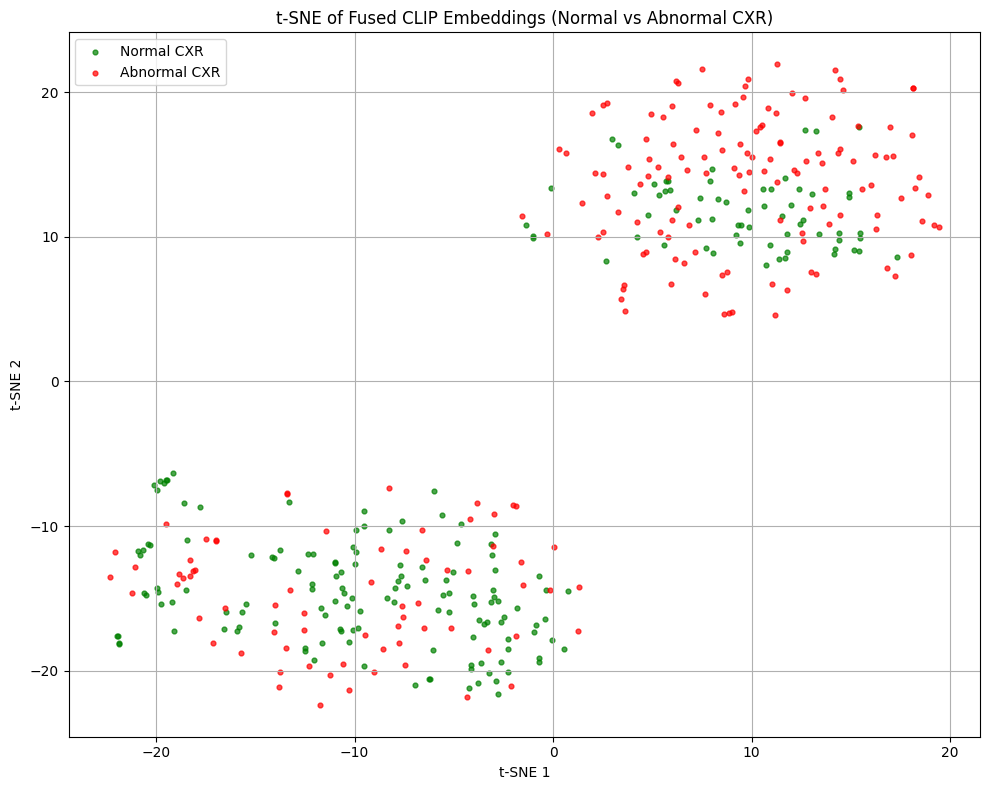

✅ Saved t-SNE plot to: fused_embeddings_tsne_binary.png


In [33]:
plot_fused_embeddings(
    model=classifier,
    dataloader=test_loader,
    device=device,
    max_points=1000  # reduce this if it's too slow
)